In [2]:
import numpy as np
import time
import scipy as sp
import pandas as pd
import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn import svm 
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.cross_validation import cross_val_score, KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from numpy import genfromtxt
import math
from sklearn import preprocessing
%matplotlib inline 

In [3]:
eros = pd.read_csv('/Users/xidexia/Desktop/eros.csv',index_col=0)
macho = pd.read_csv('/Users/xidexia/Desktop/macho.csv',index_col=0)

17.58299131016161

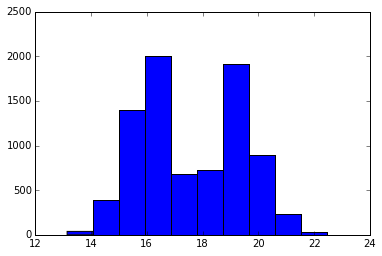

In [5]:
plt.hist(eros["Mean"])
eros["Mean"].mean()

17.66487475074988

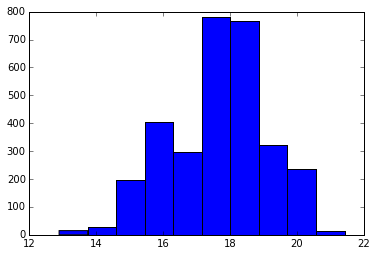

In [9]:
plt.hist(macho["Mean"]+23)
macho["Mean"].mean()+23

In [39]:
#cost_data_69 = pd.read_csv('/Users/xidexia/Desktop/299/log/readdata/cost_data_69.csv',index_col=0)
cost_data_69 = pd.read_csv('/Users/xidexia/Desktop/neweros_radec_0921.csv',index_col=0)
cost_data_69.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Color,Con,Eta_color,...,Std,StetsonJ,StetsonK,StetsonK_AC,StetsonL,Class,ID,RA,DEC,Mean Cost
0,0.08050,0.970881,1,0.283154,9.267645,0.041813,1.666029,0.216444,0,1825.803969,...,0.042416,1.523566,0.771010,0.778637,1.028974,1,lm0130l6047,69.87755,-69.23043,1.722083e-17
1,0.08175,1.000000,1,0.373134,53.154938,-0.114116,0.285270,0.392090,0,1458.708884,...,0.048401,2.543096,0.798770,0.895945,1.989471,1,lm0134k12896,69.97069,-69.83198,3.438798e-17
2,0.21475,0.992923,1,0.351852,44.787867,-0.284283,0.342989,0.470022,0,21.576843,...,0.119282,6.404891,0.780489,0.827161,4.771433,1,lm0132l17797,70.21114,-69.73800,2.095067e-17
3,0.26200,1.000000,1,0.432886,59.326615,-0.439332,0.270492,0.396497,0,86.998066,...,0.162663,9.669899,0.842464,0.900790,8.213023,1,lm0130k10679,70.22697,-69.11522,3.773741e-18
4,0.36800,1.000000,1,0.281250,51.809591,-0.561831,0.333611,0.428027,0,207.132016,...,0.231979,12.127501,0.843455,0.892794,9.736694,1,lm0132n12162,70.36245,-69.63182,1.713454e-19


(array([  1.00000000e+00,   1.30000000e+01,   1.37000000e+02,
          3.37700000e+03,   3.44100000e+03,   1.20000000e+03,
          1.40000000e+02,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([-2.52773512, -1.83440489, -1.14107466, -0.44774443,  0.24558579,
         0.93891602,  1.63224625,  2.32557648,  3.01890671,  3.71223694,
         4.40556716]),
 <a list of 10 Patch objects>)

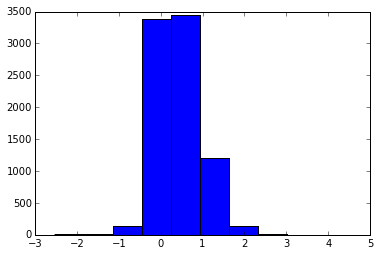

In [40]:
plt.hist(cost_data_69['Color'])

In [41]:
def RF_estimate(clf,X,y):
    if(not(y in clf.classes_)):
        return 0
    res_temp0 = clf.predict_proba(X)
    return res_temp0[:,np.flatnonzero(clf.classes_ == y)]

def max_RF_estimate(clf,X):
    return clf.predict_proba(X).max()

def proximity(clf,X,X1):
    a = clf.apply(X)
    b = clf.apply(X1)
    prox = clf.n_estimators-np.count_nonzero(a-b)
    return prox

# choose the one with highest S1 scores
def S1(clf,X_p,Xr,Xc):
    temp_train = 0.0
    for x0 in Xr:
        temp_train += float(proximity(clf,x0,X_p))
    temp_train /= float(Xr.shape[0])

    temp_test = 0.0
    for x1 in Xc:
        temp_test += float(proximity(clf,x1,X_p))
    temp_test /= float(Xc.shape[0])
    return temp_test/temp_train

# choose the one with highest S2 scores
def S2(clf,X_p,Xr,X):
    temp_test = 0.0
    for x1 in Xc:
        temp_max = max_RF_estimate(clf,x1)
        temp_test += float(proximity(clf,x1,X_p)*(1-temp_max))
    
    temp_train = 0.0
    for x0 in Xr:
        temp_train += float(proximity(clf,x0,X_p))
    temp_train += 1
    return temp_test/temp_train

def plot_with_errbars(N, data):
    x = np.arange(N)
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    valid = ~np.isnan(mean)
    plt.fill_between(x[valid], (mean-2*std)[valid], (mean+2*std)[valid], color='#d0d0d0')
    plt.plot(x[valid], mean[valid])
    
def cluster_obj_and_score_tabel(label_list,obj_uncertainty_score_list,n_cluster):
    cluster_obj_table = []
    cluster_score_table = []
    for i in xrange(n_cluster):
        idx_tmp = np.where(label_list == i)
        cluster_score_tmp = obj_uncertainty_score_list[idx_tmp].mean()
        cluster_obj_table.append(idx_tmp)
        cluster_score_table.append(cluster_score_tmp)
    return cluster_obj_table, cluster_score_table

def find_centroid_table(cluster_obj_table,center_list,n_cluster=10):
    centroid_table = []
    for i in xrange(n_cluster):
        cand_list= np.array(cluster_obj_table[i])[0]
        center_feature = center_list[i]
        tmp=[]
        for j in xrange(cand_list.shape[0]):
            tmp.append(feature_distance(cand_list[j],center_feature))
        centroid_table.append(cand_list[np.argmax(tmp)])
    return centroid_table

def feature_distance(x1,x2):
    det = x1-x2
    s =0
    for i in xrange(det.shape[0]):
        s += det[i]*det[i]
    return math.sqrt(s)

In [32]:
a = cost_data_69
X_all = np.array(a)
features = a.columns[0:64]
Y_all = np.array([int(a['Class'][i]) for i in xrange(8317)])
Xr, Xt, yr, yt = train_test_split(X_all, Y_all, train_size=6000, test_size=2317, random_state=42)
Xinit, Xsearch, yinit, ysearch = train_test_split(Xr, yr, train_size=50, test_size=5950, random_state=42)

In [33]:
Xinit_copy = Xinit
Xsearch_copy = Xsearch
Xt_copy = Xt

yinit_copy = yinit
ysearch_copy = ysearch
yt_copy = yt

In [34]:
 yt

array([7, 1, 0, ..., 3, 1, 1])

In [1]:
cost_data_69 = pd.read_csv('/Users/xidexia/Desktop/eros.csv',index_col=0)

NameError: name 'pd' is not defined

In [35]:
## create mat data
def create_mat_data(X_selected):
    Ni=X_selected.shape[0]
    Wpp = np.zeros((Ni,Ni))
    Wpp1 = np.zeros((Ni,Ni))
    Wpp2 = np.zeros((Ni,Ni))
    Wpp3 = np.zeros((Ni,Ni))


    for i in xrange(Ni):
        s=np.sum((X_selected[i,:]-X_selected[i+1:,:])**2, axis=1)
        return s
        print s

        temp=np.exp(-s)
        Wpp[i,i+1:len(temp)+i+1]=temp
        Wpp[i+1:len(temp)+i+1, i]=temp

        temp1=np.exp(-s/0.01)
        Wpp1[i,i+1:len(temp)+i+1]=temp1
        Wpp1[i+1:len(temp)+i+1, i]=temp1

        temp2=np.exp(-s/0.05)
        Wpp2[i,i+1:len(temp)+i+1]=temp2
        Wpp2[i+1:len(temp)+i+1, i]=temp2

        temp3=np.exp(-s/0.001)
        Wpp3[i,i+1:len(temp)+i+1]=temp3
        Wpp3[i+1:len(temp)+i+1, i]=temp3
    return Wpp,Wpp1,Wpp2,Wpp3

def create_01_data(Y_selected):
    num_class=2
    Y_selected_01 = np.zeros((len(Y_selected),num_class))
    for i in xrange(len(Y_selected)):
        Y_selected_01[i][int(Y_selected[i])]=1
    Y_selected_01.shape
    return Y_selected_01

## Rand

In [36]:
step = 10
num_loops = 5
N=25

In [37]:
acc_list_rand = np.zeros((num_loops,N))
time_list_rand = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
    Xlabel = Xinit
    ylabel = yinit
  
    clf_Rand = RandomForestClassifier(n_estimators=100)
    clf_Rand.fit(Xinit[:,:-5], yinit)
    
    acc_list_rand[j,0] = clf_Rand.score(Xt[:,:-5], yt)
    time_list_rand[j,0] = 0
   
    for i in xrange(N-1):
        
        X0, Xsearch, y0, ysearch = train_test_split(Xsearch, ysearch, train_size=step, test_size=Xsearch.shape[0]-step, random_state=42)
        Xlabel = np.vstack((Xlabel,X0))
        ylabel = np.append(ylabel,y0)
       
        clf_Rand = RandomForestClassifier(n_estimators=100)
        clf_Rand.fit(Xlabel[:,:-5], ylabel)

        acc_list_rand[j,i+1] = clf_Rand.score(Xt[:,:-5], yt)
        time_list_rand[j,i+1] = X0[:,-1].sum()
        
print 'Time Elapsed:', time.time()-begin 

Time Elapsed: 18.6817359924


# No cost

In [10]:
step = 10
num_loops = 3
N=25
n_cluster = 100

In [11]:
def selected_obj_list(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc, step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:-5]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
           
        dist_temp = np.array(dist_temp)/max(dist_temp)
        unct_temp = np.array(unct_temp)/max(unct_temp)
        
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(math.exp(-dist_temp[j]) + 0.35*unct_temp[j])
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
        #i = np.argsort(score_list)[-step:]
    return np.array(selected_list), score_list

In [12]:
acc_list_KM_dist_uncertainty = np.zeros((num_loops,N))
time_list_KM_dist_uncertainty = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
 
    Xlabel = Xinit
    ylabel = yinit
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = test_rf_est_list.max(axis=1)
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
    #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
        
    # uncertainty list
    Xc = Xsearch[uncertainty_idx_list]
    yc = ysearch[uncertainty_idx_list]
    obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    
    
    # remain list (high certainty)
    Xre = np.delete(Xsearch,uncertainty_idx_list,0)
    yre = np.delete(ysearch.tolist(),uncertainty_idx_list)
    
    acc_list_KM_dist_uncertainty[j,0] = clf_KM_dist_uncertainty.score(Xt[:,:-5], yt)
    time_list_KM_dist_uncertainty[j,0] =0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xc[:,:-5])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel(label_list,obj_uncertainty_score_list,n_cluster)
        
        ttt,score_list = selected_obj_list(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc, step)
        ttt_i = np.argsort(score_list)[-step:]
        Uncertainty_label_list = ttt[ttt_i]

        Xlabel = np.vstack((Xlabel,Xc[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,yc[Uncertainty_label_list])
        
        time_list_KM_dist_uncertainty[j,i+1] = Xc[Uncertainty_label_list,-1].sum()
        
        
        Xc = np.delete(Xc,Uncertainty_label_list,0)
        yc = np.delete(yc.tolist(),Uncertainty_label_list)
        Xsearch = np.vstack((Xc,Xre))
        ysearch = np.append(yc,yre)

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:-5], ylabel)
        
        acc_list_KM_dist_uncertainty[j,i+1] = clf_KM_dist_uncertainty.score(Xt[:,:-5], yt)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = test_rf_est_list.max(axis=1)
        uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
        #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]

        # uncertainty list
        Xc = Xsearch[uncertainty_idx_list]
        yc = ysearch[uncertainty_idx_list]
        obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    

        # remain list (high certainty)
        Xre = np.delete(Xsearch,uncertainty_idx_list,0)
        yre = np.delete(ysearch,uncertainty_idx_list,0)   
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
num_loops=  1
i=  0
i=  10
i=  20
num_loops=  2
i=  0
i=  10
i=  20
Time Elapsed: 115.036065102


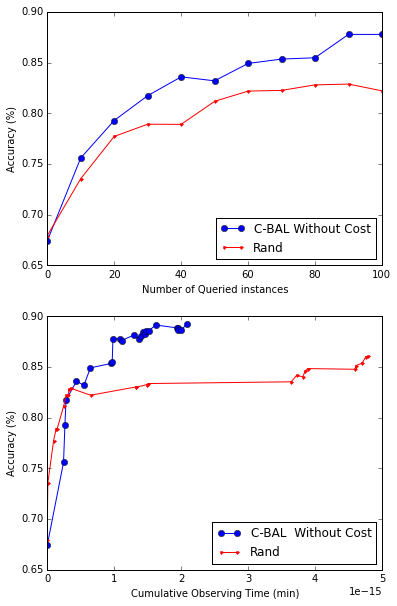

In [13]:
xx = np.array(range(N)) * step
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
#plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,100)
plt.legend(loc=4)

plt.subplot(2,1,2)
#plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
#plt.xlim(0,10000)
plt.legend(loc=4)

# cost

In [14]:
def sigmoid(x): 
    thred = 500
    if x>=thred: return 1
    else: return 0

In [15]:
def sigmoid(x): 
    thred = 500
    if x>=thred: return 1
    else: return 0

def selected_obj_list_v2(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc,step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:-5]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
            time_temp.append(Xc[idx,-1])
        #print time_temp
        dist_temp = np.array(dist_temp)/max(dist_temp)
        unct_temp = np.array(unct_temp)/max(unct_temp)
        time_temp = np.array(time_temp) #/max(time_temp)
        
        #print time_temp.max()
        #print time_temp.min()
        
        #print time_temp
        
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(math.exp(- dist_temp[j]) + 0.35*unct_temp[j] - 250*sigmoid(time_temp[j]))
            #score_temp.append(math.exp(-dist_temp[j]) + 0.35*unct_temp[j])
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
        #i = np.argsort(score_list)[-step:]
    return np.array(selected_list), score_list

In [16]:
step = 10
num_loops = 3
N=25
n_cluster = 100

In [17]:
acc_list_KM_dist_uncertainty_cost = np.zeros((num_loops,N))
time_list_KM_dist_uncertainty_cost = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
 
    Xlabel = Xinit
    ylabel = yinit
    
    
    clf_KM_dist_uncertainty_cost = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty_cost.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_KM_dist_uncertainty_cost.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = test_rf_est_list.max(axis=1)
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
    #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
        
    # uncertainty list
    Xc = Xsearch[uncertainty_idx_list]
    yc = ysearch[uncertainty_idx_list]
    obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    
    
    # remain list (high certainty)
    Xre = np.delete(Xsearch,uncertainty_idx_list,0)
    yre = np.delete(ysearch.tolist(),uncertainty_idx_list)

    acc_list_KM_dist_uncertainty_cost[j,0] = clf_KM_dist_uncertainty_cost.score(Xt[:,:-5], yt)
    time_list_KM_dist_uncertainty_cost[j,0] = 0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i

        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xc[:,:-5])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel(label_list,obj_uncertainty_score_list,n_cluster)
        
        ttt,score_list = selected_obj_list_v2(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc,step)
        ttt_i = np.argsort(score_list)[-step:]
        Uncertainty_label_list = ttt[ttt_i]
        
        Xlabel = np.vstack((Xlabel,Xc[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,yc[Uncertainty_label_list])
        
        time_list_KM_dist_uncertainty_cost[j,i+1] = Xc[Uncertainty_label_list,-1].sum()
        
        
        Xc = np.delete(Xc,Uncertainty_label_list,0)
        yc = np.delete(yc.tolist(),Uncertainty_label_list)
        Xsearch = np.vstack((Xc,Xre))
        ysearch = np.append(yc,yre)

        clf_KM_dist_uncertainty_cost = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty_cost.fit(Xlabel[:,:-5], ylabel)
        
        acc_list_KM_dist_uncertainty_cost[j,i+1] = clf_KM_dist_uncertainty_cost.score(Xt[:,:-5], yt)
        
        test_rf_est_list = clf_KM_dist_uncertainty_cost.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = test_rf_est_list.max(axis=1)
        uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
        #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]

        # uncertainty list
        Xc = Xsearch[uncertainty_idx_list]
        yc = ysearch[uncertainty_idx_list]
        obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    

        # remain list (high certainty)
        Xre = np.delete(Xsearch,uncertainty_idx_list,0)
        yre = np.delete(ysearch,uncertainty_idx_list,0)   
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
num_loops=  1
i=  0
i=  10
i=  20
num_loops=  2
i=  0
i=  10
i=  20
Time Elapsed: 113.217921972


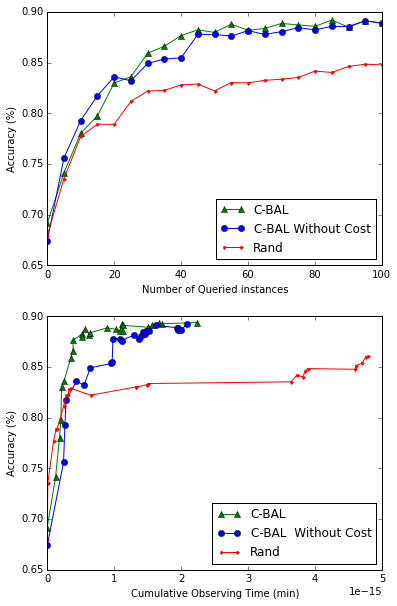

In [18]:
xx = np.array(range(N)) * 5
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,100)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
#plt.xlim(0,10000)
plt.legend(loc=4)

### Uncertainty

In [19]:
def max_RF_estimate(clf,X):
    return clf.predict_proba(X).max()

def Top_N_Uncertainty(clf,Xc,N):
    temp_list = np.zeros((Xc.shape[0],1))
    i = 0
    for x in Xc:
        temp_list[i][0] = max_RF_estimate(clf,x)
        i +=1
    return temp_list[:,0].argsort()[:N]

In [20]:
initial_size = 20
step = 10
num_loops = 3
N=25

In [21]:
acc_list_top_uncertainty = np.zeros((num_loops,N))
time_list_top_uncertainty = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
    Xlabel = Xinit
    ylabel = yinit
    
    clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_top_uncertainty.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)

    acc_list_top_uncertainty[j,0] = clf_top_uncertainty.score(Xt[:,:-5], yt)
    time_list_top_uncertainty[j,0] = 0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i
       
        Uncertainty_label_list = max_test_rf_est_list.argsort()[-10:]
        #print max_test_rf_est_list[Uncertainty_label_list]
        
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])
        
        time_list_top_uncertainty[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
         
        Xsearch = np.delete(Xsearch,Uncertainty_label_list,0)
        ysearch = np.delete(ysearch.tolist(),Uncertainty_label_list)

        clf_top_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_top_uncertainty.fit(Xlabel[:,:-5], ylabel)
        
        test_rf_est_list = clf_top_uncertainty.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = 1-test_rf_est_list.max(axis=1)
        
        acc_list_top_uncertainty[j,i+1] = clf_top_uncertainty.score(Xt[:,:-5], yt)
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
num_loops=  1
i=  0
i=  10
i=  20
num_loops=  2
i=  0
i=  10
i=  20
Time Elapsed: 18.5841510296


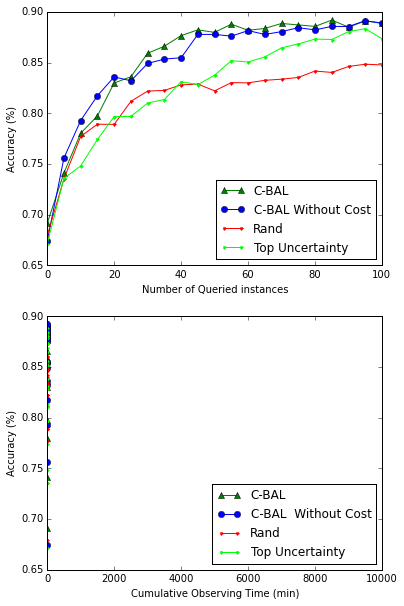

In [22]:
xx = np.array(range(N)) * 5
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(xx,acc_list_top_uncertainty.mean(axis=0),color="lime",marker=".",label="Top Uncertainty")
plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,100)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),color="lime",marker=".",label="Top Uncertainty")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,10000)
plt.legend(loc=4)

### S1

In [23]:
initial_size = 20
step = 10
num_loops = 3
N=25

In [24]:
acc_list_S1_3000_top = np.zeros((num_loops,N))
time_list_S1_3000_top = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
    Xlabel = Xinit
    ylabel = yinit
    
    clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S1_3000_top.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = test_rf_est_list.max(axis=1)
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list< 0.5)
    if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
        
    # uncertainty list
    Xc = Xsearch[uncertainty_idx_list]
    yc = ysearch[uncertainty_idx_list]
    
    # proximity
    clf_S1_3000_top.apply(Xc[:,:-5])
    
    # remain list (high certainty)
    Xre = np.delete(Xsearch,uncertainty_idx_list,0)
    yre = np.delete(ysearch.tolist(),uncertainty_idx_list)

    acc_list_S1_3000_top[j,0] = clf_S1_3000_top.score(Xt[:,:-5], yt)
    time_list_S1_3000_top[j,0] = 0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i
        PXc = clf_S1_3000_top.apply(Xc[:,:-5])
        PXlabel = clf_S1_3000_top.apply(Xlabel[:,:-5])

        S1_list=[]
        for si in xrange(Xc.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])/Xlabel.shape[0]
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])/PXc.shape[0]
            S1_list.append(1.*sn/max(0.001,sd))

        Uncertainty_label_list = np.argsort(S1_list)[-step:]
        time_list_S1_3000_top[j,i+1] = Xc[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xc[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,yc[Uncertainty_label_list])
    
        Xc = np.delete(Xc,Uncertainty_label_list,0)
        yc = np.delete(yc.tolist(),Uncertainty_label_list)
        Xsearch = np.vstack((Xc,Xre))
        ysearch = np.append(yc,yre)

        clf_S1_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S1_3000_top.fit(Xlabel[:,:-5], ylabel)
          
        acc_list_S1_3000_top[j,i+1] = clf_S1_3000_top.score(Xt[:,:-5], yt)
        
        test_rf_est_list = clf_S1_3000_top.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = test_rf_est_list.max(axis=1)
        uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<0.9)
        if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]

        # uncertainty list
        Xc = Xsearch[uncertainty_idx_list]
        yc = ysearch[uncertainty_idx_list]
        obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    

        # remain list (high certainty)
        Xre = np.delete(Xsearch,uncertainty_idx_list,0)
        yre = np.delete(ysearch,uncertainty_idx_list,0)  
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
num_loops=  1
i=  0
i=  10
i=  20
num_loops=  2
i=  0
i=  10
i=  20
Time Elapsed: 23.65583992


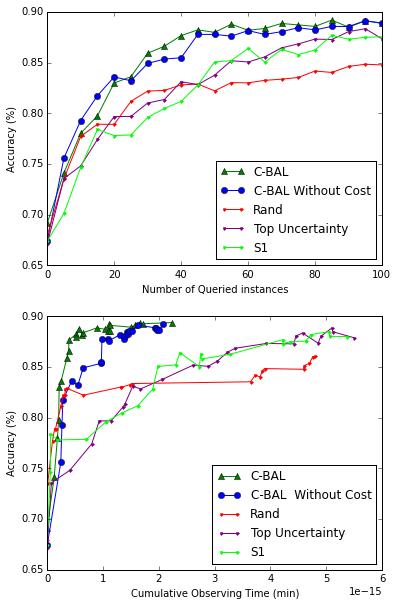

In [25]:
xx = np.array(range(N)) * 5
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(xx,acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(xx,acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,100)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
#plt.xlim(0,10000000000)
plt.legend(loc=4)

###S2

In [26]:
initial_size = 20
step = 10
num_loops = 3
N=25

In [27]:
acc_list_S2_3000_top = np.zeros((num_loops,N))
time_list_S2_3000_top = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
    Xlabel = Xinit
    ylabel = yinit
    
    clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
    clf_S2_3000_top.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = test_rf_est_list.max(axis=1)
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list< 0.5)
    if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
    u_list=1-max_test_rf_est_list[uncertainty_idx_list]
        
    # uncertainty list
    Xc = Xsearch[uncertainty_idx_list]
    yc = ysearch[uncertainty_idx_list]
    
    # proximity
    clf_S2_3000_top.apply(Xc[:,:-5])
    
    # remain list (high certainty)
    Xre = np.delete(Xsearch,uncertainty_idx_list,0)
    yre = np.delete(ysearch.tolist(),uncertainty_idx_list)

    acc_list_S2_3000_top[j,0] = clf_S2_3000_top.score(Xt[:,:-5], yt)
    time_list_S2_3000_top[j,0] = 0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i
        PXc = clf_S2_3000_top.apply(Xc[:,:-5])
        PXlabel = clf_S2_3000_top.apply(Xlabel[:,:-5])

        S2_list=[]
        for si in xrange(Xc.shape[0]):
            sd = sum([100-np.count_nonzero(PXc[si]-PXlabel[sj]) for sj in xrange(Xlabel.shape[0])])+1
            sn = sum([100-np.count_nonzero(PXc[si]-PXc[sj]) for sj in xrange(PXc.shape[0])])*u_list[si]
            S2_list.append(1.*sn/max(0.001,sd))

        Uncertainty_label_list = np.argsort(S2_list)[-step:]
        time_list_S2_3000_top[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xc[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,yc[Uncertainty_label_list])
    
        Xc = np.delete(Xc,Uncertainty_label_list,0)
        yc = np.delete(yc.tolist(),Uncertainty_label_list)
        Xsearch = np.vstack((Xc,Xre))
        ysearch = np.append(yc,yre)

        clf_S2_3000_top = RandomForestClassifier(n_estimators=100)
        clf_S2_3000_top.fit(Xlabel[:,:-5], ylabel)
          
        acc_list_S2_3000_top[j,i+1] = clf_S2_3000_top.score(Xt[:,:-5], yt)
        
        test_rf_est_list = clf_S2_3000_top.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = test_rf_est_list.max(axis=1)
        uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<0.9)
        if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
        u_list=1-max_test_rf_est_list[uncertainty_idx_list]

        # uncertainty list
        Xc = Xsearch[uncertainty_idx_list]
        yc = ysearch[uncertainty_idx_list]
        obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    

        # remain list (high certainty)
        Xre = np.delete(Xsearch,uncertainty_idx_list,0)
        yre = np.delete(ysearch,uncertainty_idx_list,0)  
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
num_loops=  1
i=  0
i=  10
i=  20
num_loops=  2
i=  0
i=  10
i=  20
Time Elapsed: 23.7397928238


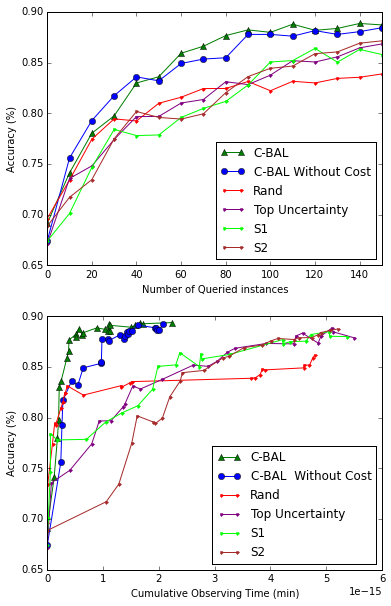

In [42]:
xx = np.array(range(N)) * 10
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(xx,acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(xx,acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(xx,acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,150)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(time_list_S2_3000_top.mean(axis=0).cumsum(),acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
#plt.xlim(0,10000)
plt.legend(loc=4)

### Zhu's paper

In [380]:
from scipy import io
aaa = sp.io.loadmat('/Users/xidexia/Desktop/query0.mat')["query0"][0]

In [383]:
initial_size = 20
step = 10
num_loops = 1
N=25

In [384]:
acc_list_zhu = np.zeros((num_loops,N))
time_list_zhu = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
    Xlabel = Xinit
    ylabel = yinit
    
    clf_zhu = RandomForestClassifier(n_estimators=100)
    clf_zhu.fit(Xinit[:,:-5], yinit)

    acc_list_zhu[j,0] = clf_zhu.score(Xt[:,:-5], yt)
    time_list_zhu[j,0] = 0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i

        Uncertainty_label_list = aaa[i*step:i*step+step]
        
        #print Uncertainty_label_list
        time_list_zhu[j,i+1] = Xsearch[Uncertainty_label_list,-1].sum()
       
        Xlabel = np.vstack((Xlabel,Xsearch[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,ysearch[Uncertainty_label_list])
    
    
        clf_zhu = RandomForestClassifier(n_estimators=100)
        clf_zhu.fit(Xlabel[:,:-5], ylabel)
          
        acc_list_zhu[j,i+1] = clf_zhu.score(Xt[:,:-5], yt)
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
Time Elapsed: 3.39093494415


In [403]:
## with cost


def selected_obj_list_v2(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc,step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:-5]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
            time_temp.append(Xc[idx,-1])
        #print time_temp
        dist_temp = np.array(dist_temp)/max(dist_temp)
        unct_temp = np.array(unct_temp)/max(unct_temp)
        time_temp = np.array(time_temp) #/max(time_temp)
        
        #print time_temp.max()
        #print time_temp.min()
        
        #print time_temp
        
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(math.exp(-dist_temp[j]) + 0.35*unct_temp[j] - 90*sigmoid(time_temp[j]))
            #score_temp.append(math.exp(-dist_temp[j]) + 0.35*unct_temp[j])
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
        #i = np.argsort(score_list)[-step:]
    return np.array(selected_list), score_list


step = 10
num_loops = 5
N=25
n_cluster = 200

acc_list_KM_dist_uncertainty_cost = np.zeros((num_loops,N))
time_list_KM_dist_uncertainty_cost = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
 
    Xlabel = Xinit
    ylabel = yinit
    
    
    clf_KM_dist_uncertainty_cost = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty_cost.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_KM_dist_uncertainty_cost.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = test_rf_est_list.max(axis=1)
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
    #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
        
    # uncertainty list
    Xc = Xsearch[uncertainty_idx_list]
    yc = ysearch[uncertainty_idx_list]
    obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    
    
    # remain list (high certainty)
    Xre = np.delete(Xsearch,uncertainty_idx_list,0)
    yre = np.delete(ysearch.tolist(),uncertainty_idx_list)

    acc_list_KM_dist_uncertainty_cost[j,0] = clf_KM_dist_uncertainty_cost.score(Xt[:,:-5], yt)
    time_list_KM_dist_uncertainty_cost[j,0] = 0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i

        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xc[:,:-5])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel(label_list,obj_uncertainty_score_list,n_cluster)
        
        ttt,score_list = selected_obj_list_v2(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc,step)
        ttt_i = np.argsort(score_list)[-step:]
        Uncertainty_label_list = ttt[ttt_i]
        
        Xlabel = np.vstack((Xlabel,Xc[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,yc[Uncertainty_label_list])
        
        time_list_KM_dist_uncertainty_cost[j,i+1] = Xc[Uncertainty_label_list,-1].sum()
        
        
        Xc = np.delete(Xc,Uncertainty_label_list,0)
        yc = np.delete(yc.tolist(),Uncertainty_label_list)
        Xsearch = np.vstack((Xc,Xre))
        ysearch = np.append(yc,yre)

        clf_KM_dist_uncertainty_cost = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty_cost.fit(Xlabel[:,:-5], ylabel)
        
        acc_list_KM_dist_uncertainty_cost[j,i+1] = clf_KM_dist_uncertainty_cost.score(Xt[:,:-5], yt)
        
        test_rf_est_list = clf_KM_dist_uncertainty_cost.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = test_rf_est_list.max(axis=1)
        uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
        #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]

        # uncertainty list
        Xc = Xsearch[uncertainty_idx_list]
        yc = ysearch[uncertainty_idx_list]
        obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    

        # remain list (high certainty)
        Xre = np.delete(Xsearch,uncertainty_idx_list,0)
        yre = np.delete(ysearch,uncertainty_idx_list,0)   
        
print 'Time Elapsed:', time.time()-begin 

num_loops=  0
i=  0
i=  10
i=  20
num_loops=  1
i=  0
i=  10
i=  20
num_loops=  2
i=  0
i=  10
i=  20
num_loops=  3
i=  0
i=  10
i=  20
num_loops=  4
i=  0
i=  10
i=  20
Time Elapsed: 798.791560888


In [ ]:
## no cost

step = 10
num_loops = 5
N=25
n_cluster = 200

def selected_obj_list(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc, step):
    selected_list = []
    score_list = []
    Xfeature =  Xc[:,:-5]
    for i in xrange(len(cluster_obj_table)):
        idx_list = cluster_obj_table[i][0]
        center = center_list[i]
        dist_temp = []
        unct_temp = []
        time_temp = []
        score_temp = []
        for j in xrange(idx_list.shape[0]):
            idx = idx_list[j]
            dist_temp.append(feature_distance(Xfeature[idx],center))
            unct_temp.append(obj_uncertainty_score_list[idx])
           
        dist_temp = np.array(dist_temp)/max(dist_temp)
        unct_temp = np.array(unct_temp)/max(unct_temp)
        
        for j in xrange(dist_temp.shape[0]):
            score_temp.append(math.exp(-dist_temp[j]) + 0.35*unct_temp[j])
        selected_list.append(idx_list[np.argmax(score_temp)])
        score_list.append(np.max(score_temp))
        #i = np.argsort(score_list)[-step:]
    return np.array(selected_list), score_list



acc_list_KM_dist_uncertainty = np.zeros((num_loops,N))
time_list_KM_dist_uncertainty = np.zeros((num_loops,N))

begin = time.time()

for j in xrange(num_loops):
    print "num_loops= ", j
    Xsearch = Xsearch_copy
    ysearch = ysearch_copy 
    Xinit = Xinit_copy
    yinit = yinit_copy 
    Xt = Xt_copy
    yt = yt_copy 
 
    Xlabel = Xinit
    ylabel = yinit
    
    clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
    clf_KM_dist_uncertainty.fit(Xinit[:,:-5], yinit)
    
    test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:-5])
    max_test_rf_est_list = test_rf_est_list.max(axis=1)
    uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
    #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]
        
    # uncertainty list
    Xc = Xsearch[uncertainty_idx_list]
    yc = ysearch[uncertainty_idx_list]
    obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    
    
    # remain list (high certainty)
    Xre = np.delete(Xsearch,uncertainty_idx_list,0)
    yre = np.delete(ysearch.tolist(),uncertainty_idx_list)
    
    acc_list_KM_dist_uncertainty[j,0] = clf_KM_dist_uncertainty.score(Xt[:,:-5], yt)
    time_list_KM_dist_uncertainty[j,0] =0
    
    for i in xrange(N-1):
        if i%10==0: print "i= ", i
        kmeans = KMeans(init='k-means++', n_clusters=n_cluster, n_init=10)
        kmeans.fit(Xc[:,:-5])
        center_list = kmeans.cluster_centers_
        label_list = np.array(kmeans.labels_.tolist())
        
        cluster_obj_table, cluster_score_table = cluster_obj_and_score_tabel(label_list,obj_uncertainty_score_list,n_cluster)
        
        ttt,score_list = selected_obj_list(cluster_obj_table, center_list, obj_uncertainty_score_list, Xc, step)
        ttt_i = np.argsort(score_list)[-step:]
        Uncertainty_label_list = ttt[ttt_i]

        Xlabel = np.vstack((Xlabel,Xc[Uncertainty_label_list]))   
        ylabel = np.append(ylabel,yc[Uncertainty_label_list])
        
        time_list_KM_dist_uncertainty[j,i+1] = Xc[Uncertainty_label_list,-1].sum()
        
        
        Xc = np.delete(Xc,Uncertainty_label_list,0)
        yc = np.delete(yc.tolist(),Uncertainty_label_list)
        Xsearch = np.vstack((Xc,Xre))
        ysearch = np.append(yc,yre)

        clf_KM_dist_uncertainty = RandomForestClassifier(n_estimators=100)
        clf_KM_dist_uncertainty.fit(Xlabel[:,:-5], ylabel)
        
        acc_list_KM_dist_uncertainty[j,i+1] = clf_KM_dist_uncertainty.score(Xt[:,:-5], yt)
        
        test_rf_est_list = clf_KM_dist_uncertainty.predict_proba(Xsearch[:,:-5])
        max_test_rf_est_list = test_rf_est_list.max(axis=1)
        uncertainty_idx_list = np.flatnonzero(max_test_rf_est_list<1)
        #if(uncertainty_idx_list.shape > 100): uncertainty_idx_list = max_test_rf_est_list.argsort()[:100]

        # uncertainty list
        Xc = Xsearch[uncertainty_idx_list]
        yc = ysearch[uncertainty_idx_list]
        obj_uncertainty_score_list = 1 - max_test_rf_est_list[uncertainty_idx_list]
    

        # remain list (high certainty)
        Xre = np.delete(Xsearch,uncertainty_idx_list,0)
        yre = np.delete(ysearch,uncertainty_idx_list,0)   
        
print 'Time Elapsed:', time.time()-begin 

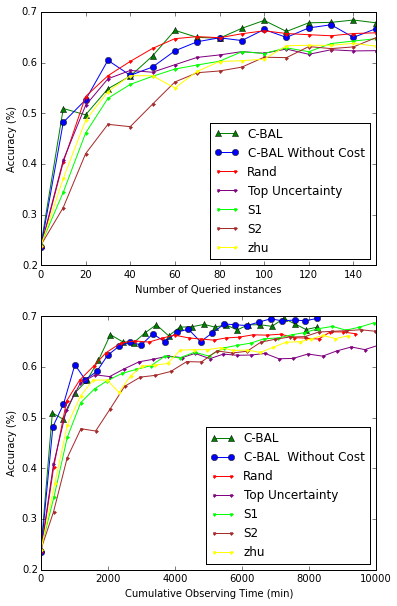

In [388]:
xx = np.array(range(25)) * 10
xx0 = np.array(range(25)) * 10
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(xx,acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(xx,acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(xx,acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")
plt.plot(xx0,acc_list_zhu.mean(axis=0),color="yellow",marker=".",label="zhu")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,150)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(time_list_S2_3000_top.mean(axis=0).cumsum(),acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")
plt.plot(time_list_zhu.mean(axis=0).cumsum(),acc_list_zhu.mean(axis=0),color="yellow",marker=".",label="zhu")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,10000)
plt.legend(loc=4)

In [389]:
acc_std0_err = acc_list_KM_dist_uncertainty_cost.std(axis=0)
acc_std1_err = acc_list_KM_dist_uncertainty.std(axis=0)
acc_std2_err = acc_list_rand.std(axis=0)
acc_std3_err = acc_list_top_uncertainty.std(axis=0)
acc_std4_err = acc_list_S1_3000_top.std(axis=0)
acc_std5_err = acc_list_S2_3000_top.std(axis=0)
acc_std6_err = acc_list_zhu.std(axis=0)


acc_sem0_err = sp.stats.sem(acc_list_KM_dist_uncertainty_cost)
acc_sem1_err = sp.stats.sem(acc_list_KM_dist_uncertainty)
acc_sem2_err = sp.stats.sem(acc_list_rand)
acc_sem3_err = sp.stats.sem(acc_list_top_uncertainty)
acc_sem4_err = sp.stats.sem(acc_list_S1_3000_top)
acc_sem5_err = sp.stats.sem(acc_list_S2_3000_top)
acc_sem6_err = sp.stats.sem(acc_list_zhu)


/Users/xidexia/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


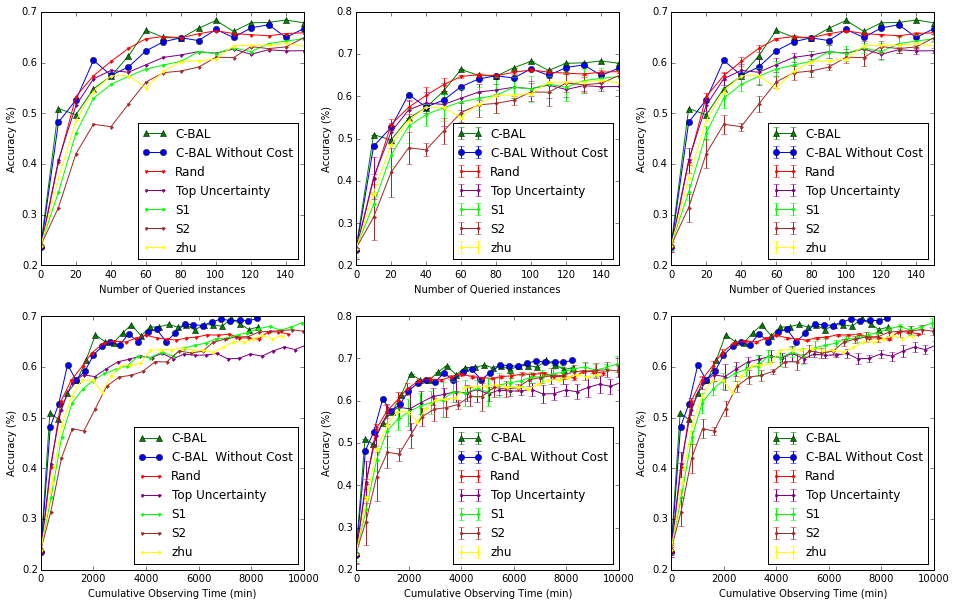

In [392]:
plt.figure(figsize = [16,10])
plt.subplot(2,3,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(xx,acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(xx,acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(xx,acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")
plt.plot(xx0,acc_list_zhu.mean(axis=0),color="yellow",marker=".",label="zhu")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
plt.xlim(0,150)
plt.legend(loc=4)

plt.subplot(2,3,2)

plt.errorbar(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),yerr=acc_std0_err,color="g",marker="^",label="C-BAL")
plt.errorbar(xx,acc_list_KM_dist_uncertainty.mean(axis=0),yerr=acc_std1_err,color="b",marker="o",label="C-BAL Without Cost")
plt.errorbar(xx,acc_list_rand.mean(axis=0),yerr=acc_std2_err,color="r",marker=".",label="Rand")
plt.errorbar(xx,acc_list_top_uncertainty.mean(axis=0),yerr=acc_std3_err,color="purple",marker=".",label="Top Uncertainty")
plt.errorbar(xx,acc_list_S1_3000_top.mean(axis=0),yerr=acc_std4_err,color="lime",marker=".",label="S1")
plt.errorbar(xx,acc_list_S2_3000_top.mean(axis=0),yerr=acc_std5_err,color="brown",marker=".",label="S2")
plt.errorbar(xx0,acc_list_zhu.mean(axis=0),yerr=acc_std6_err,color="yellow",marker=".",label="zhu")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
plt.xlim(0,150)
plt.legend(loc=4)


plt.subplot(2,3,3)

plt.errorbar(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),yerr=acc_sem0_err,color="g",marker="^",label="C-BAL")
plt.errorbar(xx,acc_list_KM_dist_uncertainty.mean(axis=0),yerr=acc_sem1_err,color="b",marker="o",label="C-BAL Without Cost")
plt.errorbar(xx,acc_list_rand.mean(axis=0),yerr=acc_sem2_err,color="r",marker=".",label="Rand")
plt.errorbar(xx,acc_list_top_uncertainty.mean(axis=0),yerr=acc_sem3_err,color="purple",marker=".",label="Top Uncertainty")
plt.errorbar(xx,acc_list_S1_3000_top.mean(axis=0),yerr=acc_sem4_err,color="lime",marker=".",label="S1")
plt.errorbar(xx,acc_list_S2_3000_top.mean(axis=0),yerr=acc_sem5_err,color="brown",marker=".",label="S2")
plt.errorbar(xx0,acc_list_zhu.mean(axis=0),yerr=acc_sem6_err,color="yellow",marker=".",label="zhu")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
plt.xlim(0,150)
plt.legend(loc=4)


plt.subplot(2,3,4)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(time_list_S2_3000_top.mean(axis=0).cumsum(),acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")
plt.plot(time_list_zhu.mean(axis=0).cumsum(),acc_list_zhu.mean(axis=0),color="yellow",marker=".",label="zhu")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,10000)
plt.legend(loc=4)


plt.subplot(2,3,5)

plt.errorbar(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),yerr=acc_std0_err,color="g",marker="^",label="C-BAL")
plt.errorbar(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),yerr=acc_std1_err,color="b",marker="o",label="C-BAL Without Cost")
plt.errorbar(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),yerr=acc_std2_err,color="r",marker=".",label="Rand")
plt.errorbar(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),yerr=acc_std3_err,color="purple",marker=".",label="Top Uncertainty")
plt.errorbar(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),yerr=acc_std4_err,color="lime",marker=".",label="S1")
plt.errorbar(time_list_S2_3000_top.mean(axis=0).cumsum(),acc_list_S2_3000_top.mean(axis=0),yerr=acc_std5_err,color="brown",marker=".",label="S2")
plt.errorbar(time_list_zhu.mean(axis=0).cumsum(),acc_list_zhu.mean(axis=0),yerr=acc_std6_err,color="yellow",marker=".",label="zhu")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,10000)
plt.legend(loc=4)

plt.subplot(2,3,6)

plt.errorbar(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),yerr=acc_sem0_err,color="g",marker="^",label="C-BAL")
plt.errorbar(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),yerr=acc_sem1_err,color="b",marker="o",label="C-BAL Without Cost")
plt.errorbar(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),yerr=acc_sem2_err,color="r",marker=".",label="Rand")
plt.errorbar(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),yerr=acc_sem3_err,color="purple",marker=".",label="Top Uncertainty")
plt.errorbar(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),yerr=acc_sem4_err,color="lime",marker=".",label="S1")
plt.errorbar(time_list_S2_3000_top.mean(axis=0).cumsum(),acc_list_S2_3000_top.mean(axis=0),yerr=acc_sem5_err,color="brown",marker=".",label="S2")
plt.errorbar(time_list_zhu.mean(axis=0).cumsum(),acc_list_zhu.mean(axis=0),yerr=acc_sem6_err,color="yellow",marker=".",label="zhu")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,10000)
plt.legend(loc=4)

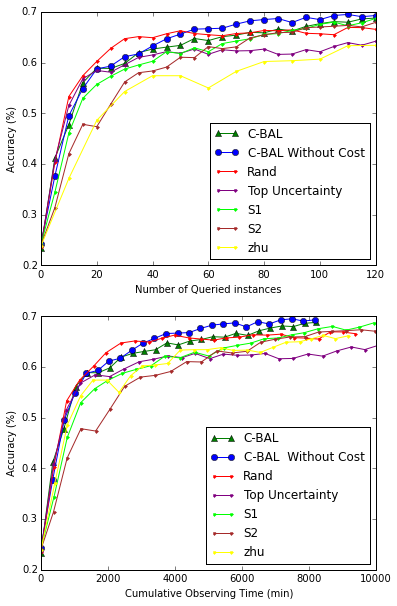

In [412]:
plt.figure(figsize = [6,10])
plt.subplot(2,1,1)
plt.plot(xx,acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(xx,acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL Without Cost")
plt.plot(xx,acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(xx,acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(xx,acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(xx,acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")
plt.plot(xx0,acc_list_zhu.mean(axis=0),color="yellow",marker=".",label="zhu")

plt.xlabel("Number of Queried instances")
plt.ylabel("Accuracy (%)")
plt.xlim(0,120)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(time_list_KM_dist_uncertainty_cost.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty_cost.mean(axis=0),color="g",marker="^",label="C-BAL")
plt.plot(time_list_KM_dist_uncertainty.mean(axis=0).cumsum(),acc_list_KM_dist_uncertainty.mean(axis=0),color="b",marker="o",label="C-BAL  Without Cost")
plt.plot(time_list_rand.mean(axis=0).cumsum(),acc_list_rand.mean(axis=0),color="r",marker=".",label="Rand")
plt.plot(time_list_top_uncertainty.mean(axis=0).cumsum(),acc_list_top_uncertainty.mean(axis=0),color="purple",marker=".",label="Top Uncertainty")
plt.plot(time_list_S1_3000_top.mean(axis=0).cumsum(),acc_list_S1_3000_top.mean(axis=0),color="lime",marker=".",label="S1")
plt.plot(time_list_S2_3000_top.mean(axis=0).cumsum(),acc_list_S2_3000_top.mean(axis=0),color="brown",marker=".",label="S2")
plt.plot(time_list_zhu.mean(axis=0).cumsum(),acc_list_zhu.mean(axis=0),color="yellow",marker=".",label="zhu")

plt.xlabel("Cumulative Observing Time (min)")
plt.ylabel("Accuracy (%)")
#plt.title("Accuracy")
plt.xlim(0,10000)
plt.legend(loc=4)